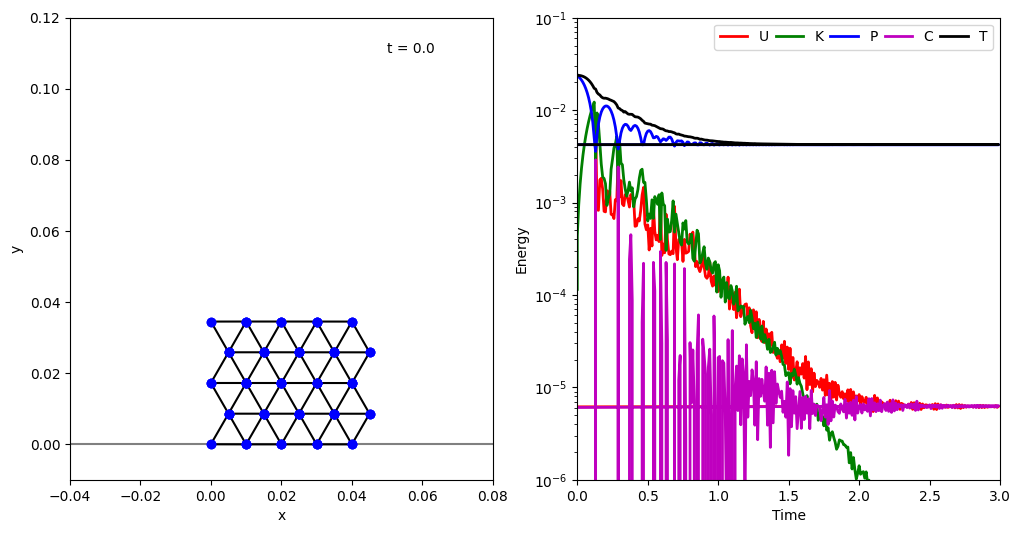

In [1]:
import numpy
import math
from matplotlib import pyplot
from matplotlib import animation

m = 0.001 # point mass [kg]
k = 1e3 # spring stiffness [kg/s^2]
L = 0.01 # spring rest length [m]
gamma = 0.005 # viscous damping coefficient [kg/s]
g = 9.81 # gravity acceleration [m/s^2]
t_end = 3.0 # simulation end time [s]
h = math.sqrt(m/k)/2 # timestep [s]
n = 5 # number of points in each direction
x0 = numpy.array([0.0, 0.08]) # initial position of lower left corner [m]
v0 = numpy.array([0.0, 0.0]) # initial velocity [m/s]

duration = 10 # video duration in secs
fps = 30 # frames per second

frames = duration * fps # number of frames
stepsPerFrame = int(round(t_end/h/frames)) # timesteps per animation frame

N = n * n # number of mass points
M = (n-1) * (3*n-1) # number of springs

class Point:
  def __init__(self):
    self.x = numpy.zeros(2) # position
    self.v = numpy.zeros(2) # velocity
    self.f = numpy.zeros(2) # force
    self.K = 0.0 # kinetic energy
    self.P = 0.0 # gravitational potential energy
    self.C = 0.0 # ground contact energy
    
  def clearForce(self):
    self.f = numpy.zeros(2)
  
  def addGravityForce(self):
    self.f[1] = self.f[1] - m * g
    self.P = m * g * self.x[1]; # gravitational potential energy
  
  def addDampingForce(self):
    self.f = self.f - gamma * self.v
    
  def addGroundForce(self):
    self.f[1] = self.f[1] - k * self.x[1] * (self.x[1] < 0)
    self.C = k/2 * self.x[1]**2 * (self.x[1] < 0) # ground contact energy
  
  def makeStep(self):
    # semi-implicit Euler
    self.v = self.v + h/m * self.f
    self.x = self.x + h * self.v
    self.K = m/2 * numpy.linalg.norm(self.v)**2 # kinetic energy

class Spring:
  def __init__(self):
    self.p1 = 0 # index of first point
    self.p2 = 0 # index of second point
    self.f = numpy.zeros(2) # spring force
    self.U = 0.0 # spring energy
  
  def computeForce(self, points):
    dx = points[self.p1].x - points[self.p2].x
    l = numpy.linalg.norm(dx)
    self.f = -k * (l - L) / l * dx # Hooke's law
    self.U = k/2 * (l - L)**2 # spring potential energy

  def addForceToPoints(self, points):
    points[self.p1].f = points[self.p1].f + self.f
    points[self.p2].f = points[self.p2].f - self.f

# initialize the mass points
points = [Point() for i in range(N)]
for i in range(n):
  for j in range(n):
    points[i*n+j].x = x0 + numpy.array([j*L + i%2 * L/2, i*L * math.sqrt(3)/2])
    points[i*n+j].v = v0

# connect the points by springs
springs = [Spring() for j in range(M)]
for i in range(n):
  for j in range(n-1):
    s1 = i*(n-1)+j
    s2 = n*(n-1) + s1
    springs[s1].p1 = i*n+j
    springs[s1].p2 = i*n+j+1
    springs[s2].p1 = j*n+i
    springs[s2].p2 = (j+1)*n+i

for i in range(n-1):
  for j in range(n-1):
    s = i*(n-1)+j + 2*n*(n-1)
    springs[s].p1 = i*n+j + (i+1) % 2
    springs[s].p2 = (i+1)*n+j + i % 2

# figure settings
fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(12, 6))
ax1.set_xlim(-0.04, 0.08)
ax1.set_ylim(-0.01, 0.12)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax2.set_yscale('log')
ax2.set_xlim(0, t_end)
ax2.set_ylim(1e-6, 1e-1)
ax2.set_xlabel('Time')
ax2.set_ylabel('Energy')

ax1.axhline(0, color='gray') # show the ground level
txt = ax1.text(0.05, 0.11, 't=0')
lines = [ax1.plot([], [], 'ko-', mec='b', mfc='b')[0] for _ in range(M)]
l1, = ax2.plot([], [], lw=2, color='r', label='U')
l2, = ax2.plot([], [], lw=2, color='g', label='K')
l3, = ax2.plot([], [], lw=2, color='b', label='P')
l4, = ax2.plot([], [], lw=2, color='m', label='C')
l5, = ax2.plot([], [], lw=2, color='k', label='T')
ax2.legend(loc="upper right", ncol=5, columnspacing=0.5)
data = [lines, l1, l2, l3, l4, l5]
t, U, K, P, C = [], [], [], [], []

# main loop
def run(frame):
  for s in range(stepsPerFrame):
    # external forces
    for i in range(N):
      points[i].clearForce()
      points[i].addGravityForce()
      points[i].addDampingForce()
      points[i].addGroundForce()
    
    # internal forces
    for j in range(M):
      springs[j].computeForce(points)
      springs[j].addForceToPoints(points)
    
    # time step
    for i in range(N):
      points[i].makeStep()
  
  # plot
  for j in range(M):
    x1 = points[springs[j].p1].x
    x2 = points[springs[j].p2].x
    data[0][j].set_data([x1[0], x2[0]], [x1[1], x2[1]])
  t.append(round(frame * stepsPerFrame * h, 2))
  U.append(sum([springs[j].U for j in range(M)]))
  K.append(sum([points[i].K for i in range(N)]))
  P.append(sum([points[i].P for i in range(N)]))
  C.append(sum([points[i].C for i in range(N)]))
  T = numpy.array([U,K,P,C]).sum(axis=0)
  data[1].set_data(t, U)
  data[2].set_data(t, K)
  data[3].set_data(t, P)
  data[4].set_data(t, C)
  data[5].set_data(t, T)
  txt.set_text('t = ' + str(t[-1]))
  return data

anim = animation.FuncAnimation(fig, run, frames=frames, interval=1000/fps)
anim.save('mass_spring.mp4', fps=fps, extra_args=['-vcodec', 'libx264'])
